# Dice throws vs coin-flipping

Infering parameters of the dice can be reduced to the coin flipping problem.
However, there are some issues which are not discussed too often.
In the following we are analysing the behaviour of a three-sided dice.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import numpy.random as rnd
import itertools

from pandas import Series
from pandas import DataFrame
from typing import List

from tqdm import tnrange
from plotnine import *

## IV. Rejection sampling

Posterior distributions are usually hard to model, since we can get the density function up to a constant. In the following we consider a simple technique that allows us to simulate posterior distribution. We state this in term of two dimensional distributions but it is applicable for any dimension.

Let $f(p_1, p_2)$ be a function that is proportional to the density $g(p_1,p_2)$ of our target distribution.
Let the target distribution be defined inside a some known region $\mathcal{X}$. For dice throwing, we know that $(p_1,p_2)\in[0,1]\times[0,1]$. Moreover let $f(p_1,p_2)\in[0,1]$ for all $(p_1,p_2)\in\mathcal{X}$. Then the following procedure produces samples form the target distribution:

1. Sample $(p_1,p_2)$ uniformly from the region $\mathcal{X}$.
2. Accept the point $(p_1,p_2)$ with probability $f(p_1,p_2)$.
3. If point was rejected start from the Step 1.

Note that the probability that $(p_1,p_2)$ is accepted in a cycle is

\begin{align*}
\Pr[(p_1,p_2)\gets\mathcal{X}, u\gets [0,1]: u\leq f(p_1,p_2)] = \int_0^1 f(p_1,p_2) dp_1 dp_2
\end{align*}

Thus the conditional density

\begin{align*}
p[(p_1,p_2)|(p_1,p_2) \text{ is accepted}] = \frac{f(p_1,p_2)}{\int_0^1 f(p_1,p_2) dp_1 dp_2}=g(p_1,p_2)\enspace.
\end{align*}

Note that the similar procedure works if we sample points with density $\pi(p_1,p_2)$ but then we need to recalibrate the acceptance probability:

1. Sample $(p_1,p_2)$ with density $\pi(p_1,p_2)$ from the region $\mathcal{X}$.
2. Accept the point $(p_1,p_2)$ with probability $\frac{f(p_1,p_2)}{\pi(p_1,p_2)}$.
3. If point was rejected start from the Step 1.

Again the probability that $(p_1,p_2)$ is accepted in a cycle is

\begin{align*}
\Pr\biggl[(p_1,p_2)\gets\mathcal{X}, u\gets [0,1]: u\leq \frac{f(p_1,p_2)}{\pi(p_1,p_2)}\biggr] = \int_0^1 \pi(p_1,p_2)\cdot \frac{f(p_1,p_2)}{\pi(p_1,p_2)} dp_1 dp_2
\end{align*}

Thus the conditional density

\begin{align*}
p[(p_1,p_2)|(p_1,p_2) \text{ is accepted}] = \frac{\pi(p_1,p_2)\cdot \frac{f(p_1,p_2)}{\pi(p_1,p_2)}}{\int_0^1 f(p_1,p_2) dp_1 dp_2}=g(p_1,p_2)\enspace.
\end{align*}

**Important:** As we cannot accept point with greater probability it is imporatnt that $f(p_1,p_2)\leq \pi(p_1,p_2)$ for any $(p_1,p_2)\in\mathcal{X}$.

**Solution:** If we know the point $(p_1^*,p_2^*)$ that maximises function $\frac{f(p_1,p_2)}{\pi(p_1,p_2)}$ then we can always scale $f$ to meet the criterion:
* For uniform sampling, we need to know the maximum aposteriori estimate.  


# Homework

## 8.1 Full posterior for dice throwing (<font color='red'>1p</font>)

Use rejection sampling to get a $10000$ independent samples from the posterior distribution for $5$ ones, $10$
twos and $5$ threes, i.e., for parameter values $k_1=5, k_2=10, k_3=5$. Draw the corresponding twodimensional density plot and corresponding marginal distributions for the parameters $p_1$ and $p_2$.

**Extra point:**
Compute also product of marginal distributions and compare it with the full posterior. Is the full posterior a product of two marginal distributions or there is a dependency between $p_1$ and $p_2$.  


## Solution

**We used rejection sampling to get $10000$ independent samples from the posterior distribution for the three-sided dice having observed $k_1 = 5$ ones, $k_2 = 10$ twos, and $k_3 = 5$ threes, and having assumed a uniform prior. Samples were accepted proportional to the likelihoods (which is proportional to the posterior in case of uniform prior) which were scaled by the likelihood of the maximum a posteriori estimate (otherwise we would wait forever to accept any samples).**

In [2]:
N = 10000
k1 = 5
k2 = 10
k3 = 5
n = k1 + k2 + k3
MAP_estimate = (k1/n)**k1 * (k2/n)**k2 * (k3/n)**k3

posterior = DataFrame(columns = ['p1', 'p2'])
nrows = posterior.shape[0]

while nrows < N:
    samples = DataFrame({'p1': rnd.uniform(size = N - nrows), 'p2': rnd.uniform(size = N - nrows)}) \
        .query('p1 + p2 <= 1') \
        .assign(p3 = lambda df: 1 - df.p1 - df.p2,
                likelihood = lambda df: df['p1']**k1 * df['p2']**k2 * df['p3']**k3 / MAP_estimate,
                u = lambda df: rnd.uniform(size = df.shape[0]))
    
    posterior = posterior.append(samples.loc[samples.u < samples.likelihood, ['p1', 'p2']])
    nrows = posterior.shape[0]
    
posterior = posterior.reset_index(drop = True)

**We then visualized the joint posterior distribution of $(p_1, p_2)$ together with marginal distributions for both $p_1$ and $p_2$.**

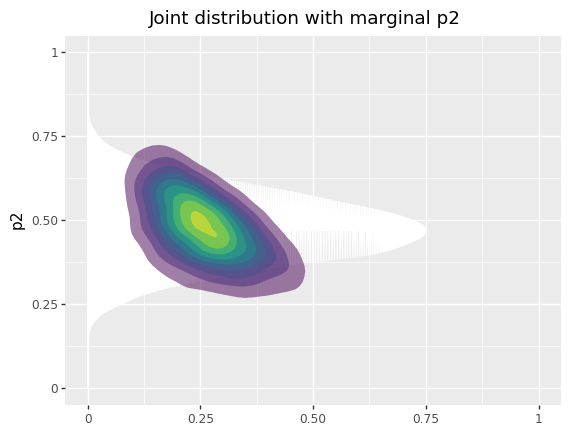

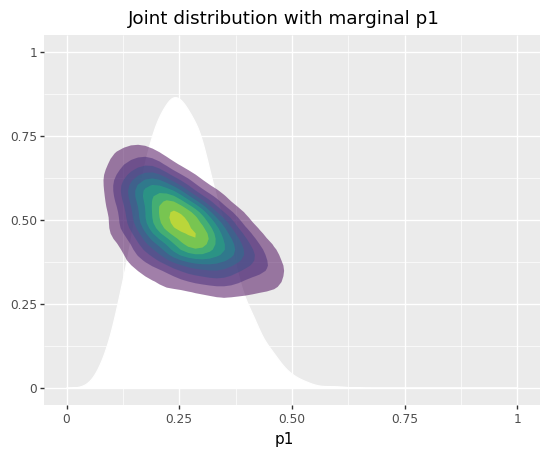

[<ggplot: (-9223372029301876764)>, <ggplot: (7552895643)>]

In [3]:
gg_p1 = ggplot(posterior) + \
    geom_density(aes(x = 'p1', y = '..density.. / 5'), fill = 'white', colour = 'white') + \
    stat_density_2d(aes(x = 'p1', y = 'p2', fill = '..level..'), levels = 10, geom = 'polygon', alpha = 0.5) + \
    scale_x_continuous(limits = [0, 1]) + \
    scale_y_continuous(limits = [0, 1]) + \
    theme(legend_position = 'none',
          axis_title_y = element_blank()) + \
    ggtitle('Joint distribution with marginal p1')

gg_p2 = ggplot(posterior) + \
    geom_density(aes(x = 'p2', y = '..density.. / 5'), fill = 'white', colour = 'white') + \
    stat_density_2d(aes(x = 'p2', y = 'p1', fill = '..level..'), levels = 10, geom = 'polygon', alpha = 0.5) + \
    scale_x_continuous(limits = [0, 1]) + \
    scale_y_continuous(limits = [0, 1]) + \
    coord_flip() + \
    theme(legend_position = 'none',
          axis_title_x = element_blank()) + \
    ggtitle('Joint distribution with marginal p2')

display([gg_p2, gg_p1])

**The marginal densities in the above figure are scaled down a bit for visualisation purposes. However, we can see that they nicely match with the joint density.**

**To get the product of marginal distributions from our samples, we created every possible combination of $p_1$ and $p_2$, in total $10^4 \times 10^4 = 10^8$ points, and then randomly sampled $10^5$ points for the visualisation.**

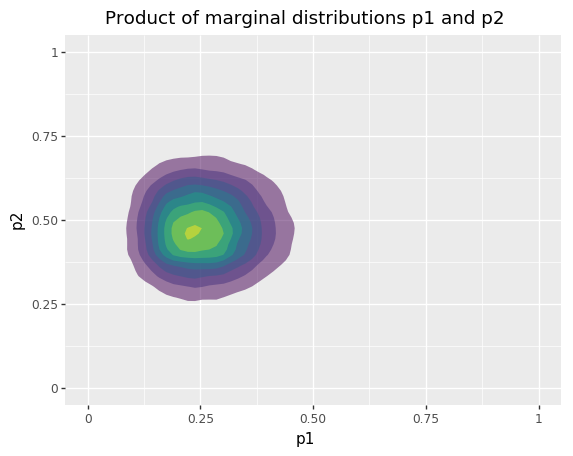

<ggplot: (7552895615)>

In [4]:
marginal_product = list(itertools.product(posterior.loc[:, 'p1'], posterior.loc[:, 'p2']))
marginal_product = DataFrame(marginal_product, columns = ['p1', 'p2']).sample(100000)

ggplot(marginal_product) + \
    stat_density_2d(aes(x = 'p1', y = 'p2', fill = '..level..'), levels = 10, geom = 'polygon', alpha = 0.5) + \
    scale_x_continuous(limits = [0, 1]) + \
    scale_y_continuous(limits = [0, 1]) + \
    theme(legend_position = 'none') + \
    ggtitle('Product of marginal distributions p1 and p2')

**It is clear that the full joint posterior of $(p_1, p_2)$ is not the product of two marginal distributions, i.e. there is dependency between $p_1$ and $p_2$.**